<a href="https://colab.research.google.com/github/Ren-Ps/sky130_gm_id_method/blob/main/sky130_pyspice_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SKY130 PySpice playground

```
Copyright 2022 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

Analyse behavior of spice models from the [open source SKY130 PDK](https://github.com/google/skywater-pdk/) using [PySpice](https://pyspice.fabrice-salvaire.fr/).

## Setup

In [ ]:
#@title Bootstrap conda environment {display-mode: "form"}
#@markdown - Click the ▷ button to initialize the conda-eda environment.
#@markdown - Wait for the installation to complete
#@markdown - Click the `Restart Kernel` button.
%pip install -q https://github.com/conda-incubator/condacolab/archive/28521d7c5c494dd6377bb072d97592e30c44609c.tar.gz
import condacolab

condacolab.install(restart_kernel=False)

     - 35 kB 2.5 MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Please restart kernel...


Button(description='Restart kernel now...', style=ButtonStyle())

Output(layout=Layout(border='1px solid black'))

## Install dependencies

- Wait for the kernel restart to complete.
- Click the ▷ button below to run the hidden cells to complete the setup.


In [ ]:
%%writefile environment.yml
channels:
  - litex-hub
  - conda-forge
dependencies:
  - open_pdks.sky130a
  - pyspice
  - tqdm

Overwriting environment.yml


In [ ]:
!mamba env update -n base -f environment.yml

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
[+] 0.0s
[+] 0.1s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  [+] 0.2s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  litex-hub/noarch                                              No change
litex-hub/linux-64                                            No change


Looking for: ['open_pdks.sky130a', 'pyspice', 'tqdm']



  Pinned packages:

  - python 3.7.*
  - python_abi 3.7.* *cp37*
  - cudatoolkit 11.2.*


Transaction

  Prefix: /usr/local

  Updating specs:

   - open_pdks.sky130a
   - pyspice
   - tqdm


  Package                         Version  Build            Channel                Size
─────────────────────────────────────────────────────────────────────────────────────────
  Change:
─────────────────────────────────────────────────────────────────────────────────────────

  - open_pdks.sky130a  1.0.342_0_gde752ec  20220921_210118  l

## Simulate nfet_01v8 with PySpice

### Define circuit

In [ ]:
import PySpice.Spice.Simulation
PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = 'ngspice-shared'

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

def sky130_circuit(cell, vdd, w, l):
  circuit = Circuit('nfet_01v8')
  circuit.lib('/usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice', 'tt')
  Vgate = circuit.V('gate', 'vg', circuit.gnd, 0@u_V)
  Vdrain = circuit.V('drain', 'vdd', circuit.gnd, u_V(vdd))
  circuit.X('cell', cell, 'vdd', 'vg', circuit.gnd, circuit.gnd, w=w, l=l)
  return circuit

circuit = sky130_circuit('sky130_fd_pr__nfet_01v8', 1.8, w=10, l=1.15)
print(str(circuit))

.title nfet_01v8
.lib /usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice tt
Vgate vg 0 0V
Vdrain vdd 0 1.8V
Xcell vdd vg 0 0 sky130_fd_pr__nfet_01v8 l=1.15 w=10



### Run simulation

Unsupported Ngspice version 37


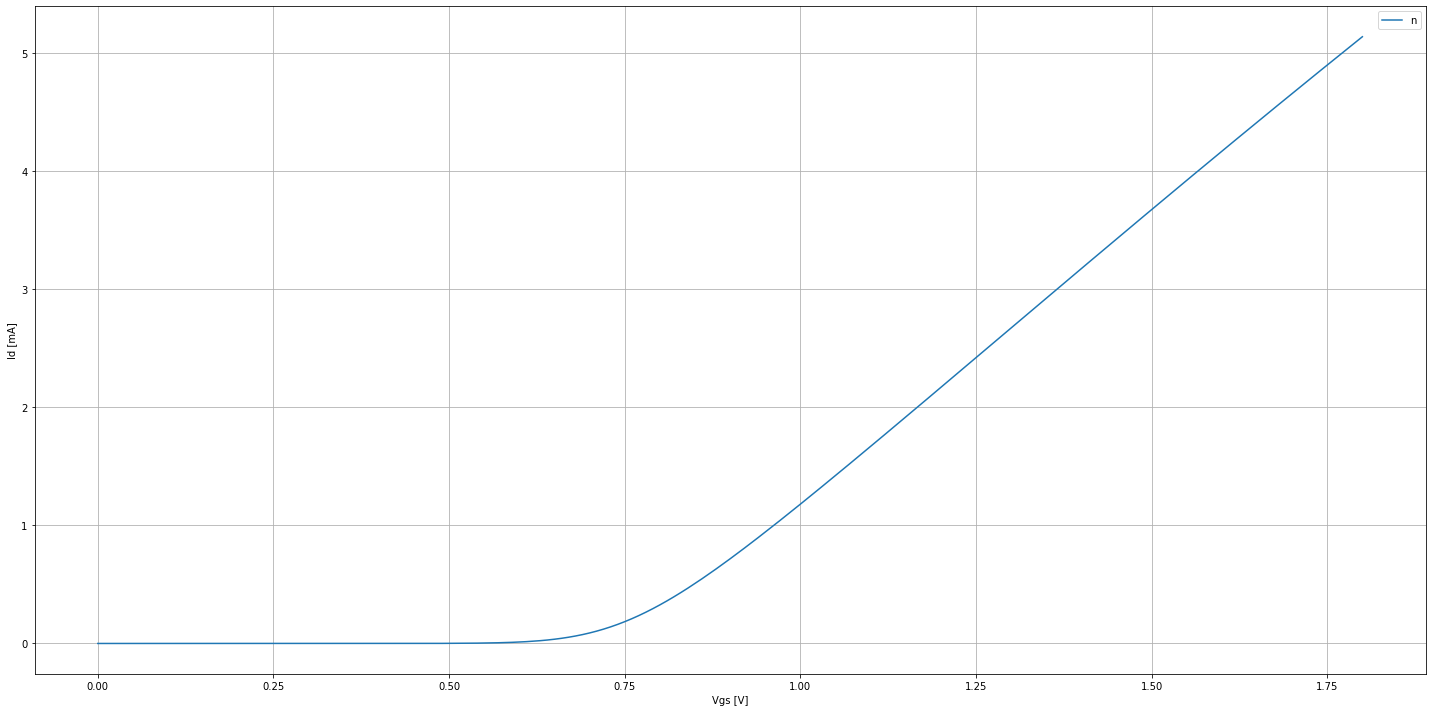

In [ ]:
import PySpice.Spice.Simulation
PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = 'ngspice-shared'

def sky130_simulate_dc(cell, sweep, **kwargs):
  circuit = sky130_circuit(cell, sweep.stop, **kwargs)
  simulator = circuit.simulator(temperature=25, nominal_temperature=25)
  analysis = simulator.dc(Vgate=sweep)
  vgs = analysis['vg']
  id = u_mA(-analysis.Vdrain)
  return (vgs, id)

vgs, id = sky130_simulate_dc('sky130_fd_pr__nfet_01v8',
                             sweep=slice(0, 1.8, .01),
                             w=10, l=0.15)

%matplotlib inline
import matplotlib.pyplot as plt

figure, ax = plt.subplots(figsize=(20, 10))
ax.plot(vgs, id)
ax.legend('nfet_01v8')
ax.grid()
ax.set_xlabel('Vgs [V]')
ax.set_ylabel('Id [mA]')

plt.tight_layout()
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

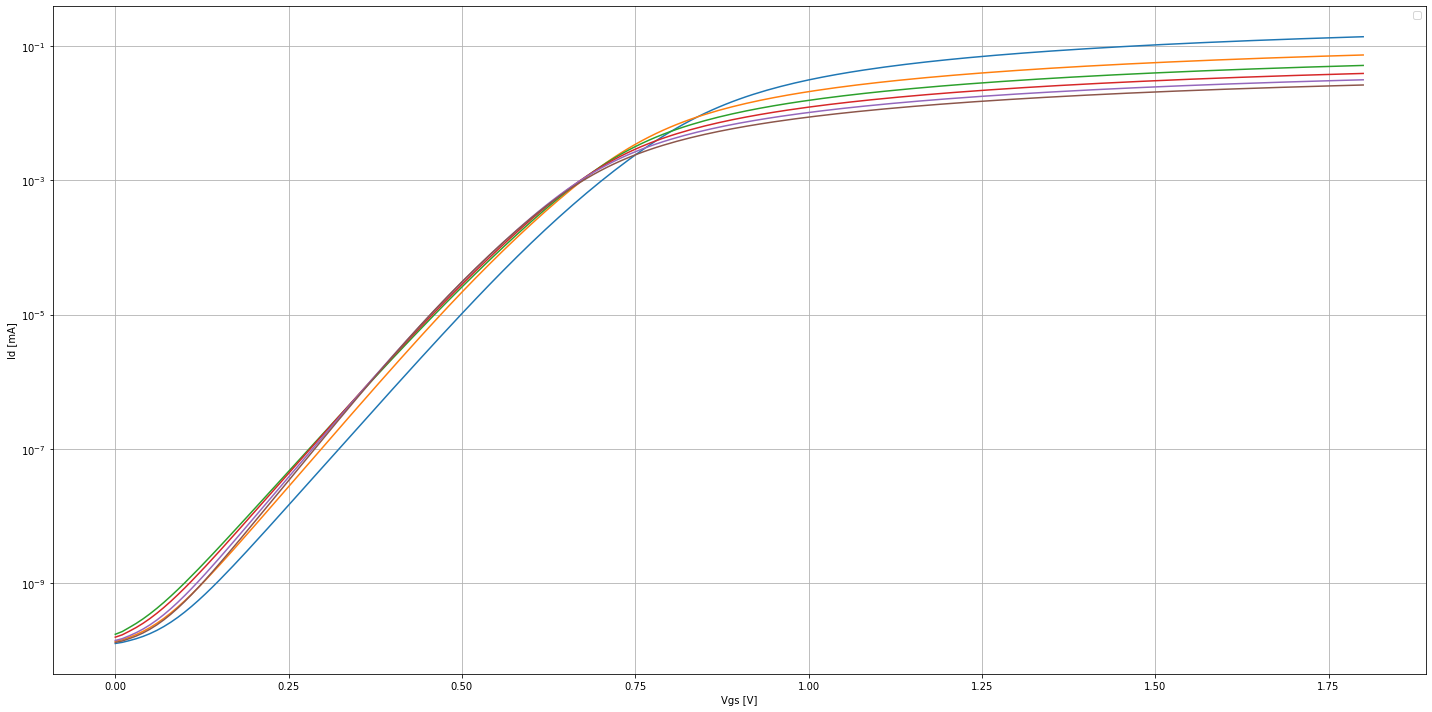

In [ ]:
%matplotlib inline
import itertools
import numpy as np
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import PySpice.Math.Calculus

def sky130_simulate_dc(cell, bias, sweep, w, l):
  circuit = sky130_circuit(cell, bias, w=w, l=l)
  simulator = circuit.simulator(temperature=25, nominal_temperature=25)
  analysis = simulator.dc(Vgate=sweep)
  vgs = analysis['vg']
  id = u_mA(-analysis.Vdrain)
  return (vgs, id)

ws = [1]
ls = np.arange(0.15, 1, 0.15)

figure, ax = plt.subplots(figsize=(20, 10))
ax.legend('nfet_01v8')
ax.grid()
ax.set_xlabel('Vgs [V]')
ax.set_ylabel('Id [mA]')
ax.set_yscale('log')

for w, l in tqdm.tqdm(itertools.product(ws, ls), total=len(ws)*len(ls)):
  vgs, id = sky130_simulate_dc('sky130_fd_pr__nfet_01v8',
                               bias=0.1,
                               sweep=slice(0, 1.8, .01),
                               w=w, l=l)
  #ddid = PySpice.Math.Calculus.derivative(vgs, id, 2)
  ax.plot(vgs, id)

plt.tight_layout()
plt.show()

### Run OP simulations across device parameters sweep

In [ ]:
%matplotlib inline

import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import tqdm.notebook as tqdm
import pandas as pd

def sky130_simulate_op(cell, bias, ws, ls):
  for w, l in itertools.product(ws, ls):
    circuit = sky130_circuit(cell, bias, w=w, l=l)
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.operating_point()
    id = u_mA(-analysis.Vdrain)
    yield w, l, float(id[0])

ws = [10]
ls = [0.15, 0.17, 0.18, 0.19, 0.24, 0.25, 0.26, 0.4, 0.5, 0.6, 0.9, 1, 1.1, 1.9, 2, 2.1, 3.9, 4, 4.1, 7, 8, 9, 15, 20, 25, 90, 100]

values = tqdm.tqdm(
    sky130_simulate_op('sky130_fd_pr__nfet_01v8', 1.8, ws, ls),
    total=len(ws)*len(ls)
)
values = list(values)
df = pd.DataFrame.from_records(values, columns=('W', 'L', 'ID'))
df

  0%|          | 0/27 [00:00<?, ?it/s]

,W,L,ID
0,10,0.15,2.419442e-12
1,10,0.17,3.851131e-12
2,10,0.18,4.336873e-12
3,10,0.19,4.701383e-12
4,10,0.24,3.068402e-12
5,10,0.25,2.854586e-12
6,10,0.26,2.871755e-12
7,10,0.40,2.861234e-12
8,10,0.50,2.773280e-12
9,10,0.60,2.699133e-12


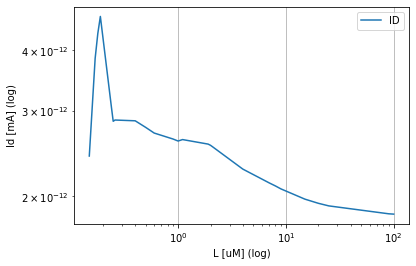

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

ax = df.plot(x='L', y='ID')
ax.grid()
ax.set_xlabel('L [uM] (log)')
ax.set_ylabel('Id [mA] (log)')
ax.set_xscale('log')
ax.set_yscale('log')
ax